## **Google Drive to access dataset**

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing all the Libraries needed**

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)


True

## **Loading the dataset and having an Initial Data Overview**

In [94]:
file_path = '/content/drive/MyDrive/ANLP/train.csv'

df = pd.read_csv(file_path)
df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## **Plot Label Distribution**

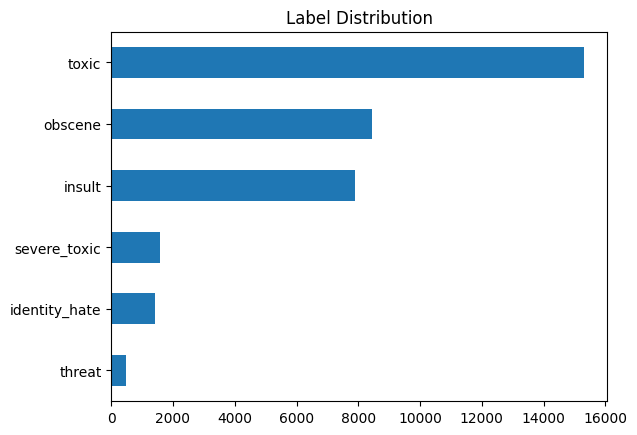

In [95]:
toxicity_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df[toxicity_labels].sum().sort_values().plot(kind='barh', title='Label Distribution')
plt.show()


## **Plot Distribution of Comment Length (Words)**

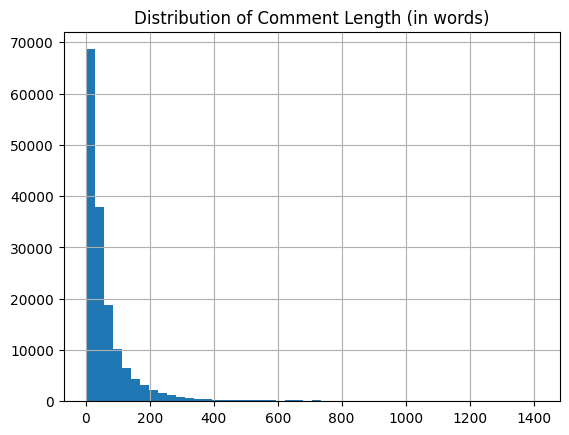

In [96]:
df['word_count'] = df['comment_text'].str.split().apply(len)
df['word_count'].hist(bins=50)
plt.title("Distribution of Comment Length (in words)")
plt.show()


##**Text Preprocessing: Tokenization, Lemmatization, Stopword Removal**


In [97]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Defining the preprocessing function
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"http\\S+|www\\S+|https\\S+", '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\\d+', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return ' '.join(tokens)

# Applying it to the dataset
df['clean_comment'] = df['comment_text'].apply(preprocess_text)



In [98]:
df = df[df['clean_comment'].str.len() > 0].copy()
print(f"Comments After preprocessing: {df.shape[0]} comments remaining")

Comments After preprocessing: 159552 comments remaining


## **Word Cloud for Toxic Comments**

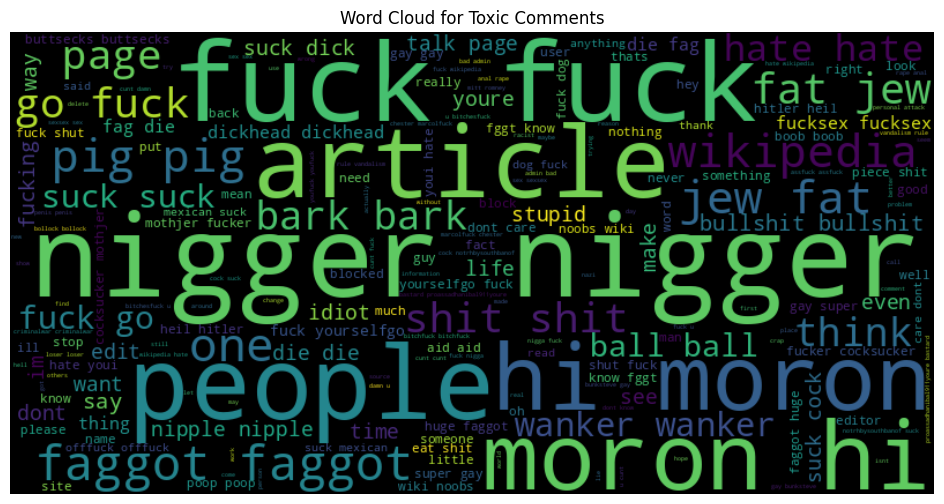

In [99]:
from wordcloud import WordCloud

text = ' '.join(df[df['toxic'] == 1]['clean_comment'])
wordcloud = WordCloud(width=800, height=400).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Toxic Comments")
plt.show()


## **Creating 'is_toxic' Column and Analyzing Class Balance**

In [100]:
df['label_sum'] = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
df['is_toxic'] = df['label_sum'] > 0
df['is_toxic'].value_counts(normalize=True)


,proportion
is_toxic,
False,0.898309
True,0.101691


<Axes: title={'center': 'Number of Labels per Comment'}, xlabel='label_count'>

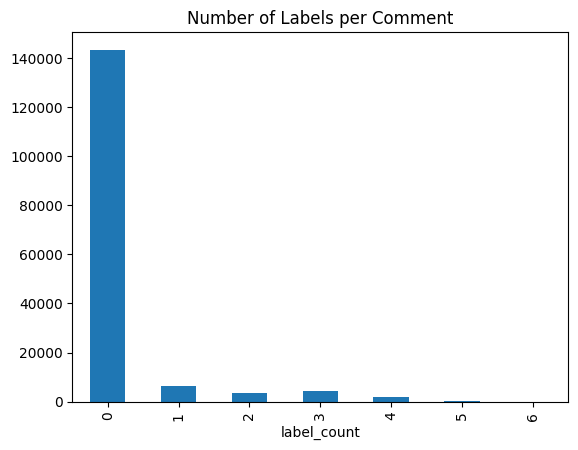

In [101]:
df['label_count'] = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
df['label_count'].value_counts().sort_index().plot(kind='bar', title="Number of Labels per Comment")


In [102]:
df['char_length'] = df['comment_text'].apply(len)
df['clean_length'] = df['clean_comment'].apply(len)

df[['char_length', 'clean_length']].describe()


,char_length,clean_length
count,159552.000000,159552.000000
mean,394.116927,251.334624
std,590.741866,390.500468
min,6.000000,1.000000
25%,96.000000,60.000000
50%,205.000000,129.000000
75%,436.000000,274.000000
max,5000.000000,5000.000000


In [103]:
df['is_clean'] = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) == 0

# to View the first few rows including is_clean
df[['comment_text', 'is_clean']].head()


,comment_text,is_clean
0,Explanation\nWhy the edits made under my usern...,True
1,D'aww! He matches this background colour I'm s...,True
2,"Hey man, I'm really not trying to edit war. It...",True
3,"""\nMore\nI can't make any real suggestions on ...",True
4,"You, sir, are my hero. Any chance you remember...",True


## **Feature Extraction Using TF-IDF Vectorizer**

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use the cleaned text
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)
X = vectorizer.fit_transform(df["clean_comment"])  # Sparse matrix
y = df[toxicity_labels].values
print(f"Feature matrix shape is: {X.shape}")

Feature matrix shape is: (159552, 10000)


**Split Dataset into Training and Test Sets**

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (127641, 10000)
Test set: (31911, 10000)


## **Logistic regression**



In [106]:
# Prepare: models, thresholds, and results containers
models = {}
thresholds = {}
results = {}

In [107]:
# Train Logistic Regression per label with oversampling + class weights + threshold tuning
for i, label in enumerate(toxicity_labels):
    print(f"\nTraining model for '{label}'...")

    # Oversample minority class in training set for this label
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train[:, i])

    # Logistic Regression with class weighting
    clf = LogisticRegression(class_weight='balanced', max_iter=1000)
    clf.fit(X_resampled, y_resampled)
    models[label] = clf

    # Predict probabilities on test set
    y_prob = clf.predict_proba(X_test)[:, 1]

    # Threshold tuning by maximizing F1-score
    best_thresh = 0.5
    best_f1 = 0
    for t in np.arange(0.1, 0.9, 0.01):
        y_pred_t = (y_prob >= t).astype(int)
        f1 = f1_score(y_test[:, i], y_pred_t, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    thresholds[label] = best_thresh
    y_pred = (y_prob >= best_thresh).astype(int)

        # Save metrics
    results[label] = {
        'accuracy': accuracy_score(y_test[:, i], y_pred),
        'precision': precision_score(y_test[:, i], y_pred, zero_division=0),
        'recall': recall_score(y_test[:, i], y_pred, zero_division=0),
        'f1_score': best_f1,
        'roc_auc': roc_auc_score(y_test[:, i], y_prob)
    }

    print(f"{label.upper()} threshold: {best_thresh:.2f}")
    print(f"Accuracy:  {results[label]['accuracy']:.4f}")
    print(f"Precision: {results[label]['precision']:.4f}")
    print(f"Recall:    {results[label]['recall']:.4f}")
    print(f"F1-Score:  {results[label]['f1_score']:.4f}")
    print(f"ROC-AUC:   {results[label]['roc_auc']:.4f}")


Training model for 'toxic'...
TOXIC threshold: 0.78
Accuracy:  0.9563
Precision: 0.7835
Recall:    0.7422
F1-Score:  0.7623
ROC-AUC:   0.9628

Training model for 'severe_toxic'...
SEVERE_TOXIC threshold: 0.89
Accuracy:  0.9856
Precision: 0.3708
Recall:    0.6624
F1-Score:  0.4754
ROC-AUC:   0.9814

Training model for 'obscene'...
OBSCENE threshold: 0.86
Accuracy:  0.9793
Precision: 0.8342
Recall:    0.7638
F1-Score:  0.7974
ROC-AUC:   0.9756

Training model for 'threat'...
THREAT threshold: 0.88
Accuracy:  0.9961
Precision: 0.4211
Recall:    0.5490
F1-Score:  0.4766
ROC-AUC:   0.9807

Training model for 'insult'...
INSULT threshold: 0.81
Accuracy:  0.9685
Precision: 0.6661
Recall:    0.7401
F1-Score:  0.7012
ROC-AUC:   0.9698

Training model for 'identity_hate'...
IDENTITY_HATE threshold: 0.88
Accuracy:  0.9883
Precision: 0.3924
Recall:    0.5887
F1-Score:  0.4709
ROC-AUC:   0.9717


In [108]:
# Combined prediction with tuned thresholds
y_pred_all = np.zeros_like(y_test)
for i, label in enumerate(toxicity_labels):
    prob = models[label].predict_proba(X_test)[:, 1]
    y_pred_all[:, i] = (prob >= thresholds[label]).astype(int)

In [109]:
# Classification reports per label
for i, label in enumerate(toxicity_labels):
    print(f"\nClassification report for '{label}':")
    print(classification_report(y_test[:, i], y_pred_all[:, i]))


Classification report for 'toxic':
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     28897
           1       0.78      0.74      0.76      3014

    accuracy                           0.96     31911
   macro avg       0.88      0.86      0.87     31911
weighted avg       0.96      0.96      0.96     31911


Classification report for 'severe_toxic':
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     31597
           1       0.37      0.66      0.48       314

    accuracy                           0.99     31911
   macro avg       0.68      0.83      0.73     31911
weighted avg       0.99      0.99      0.99     31911


Classification report for 'obscene':
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     30205
           1       0.83      0.76      0.80      1706

    accuracy                           0.98     31911
   macro av

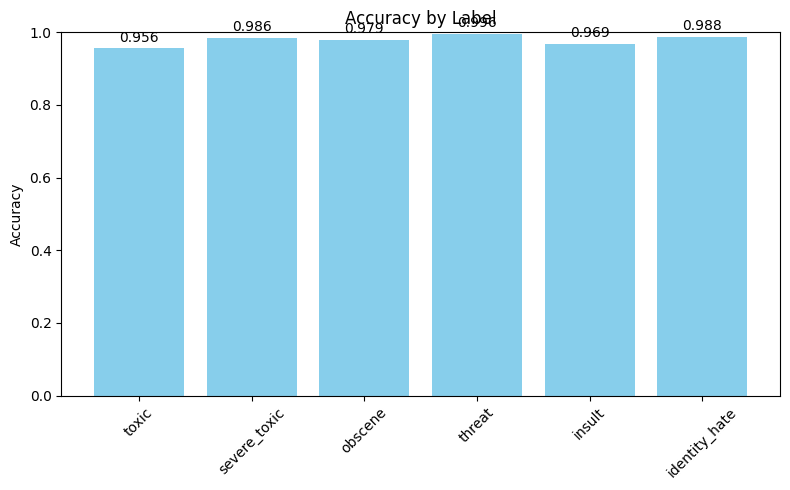

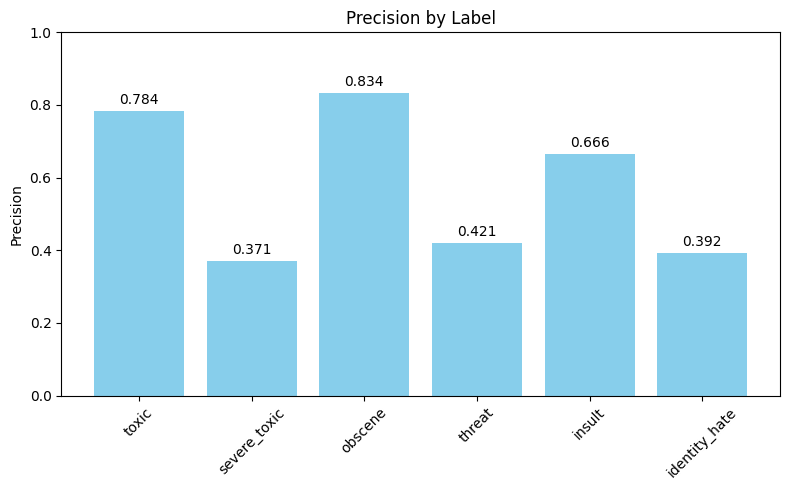

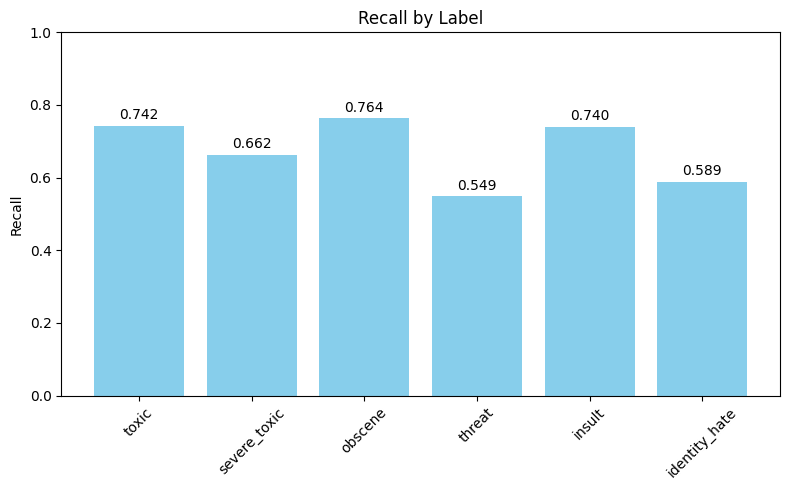

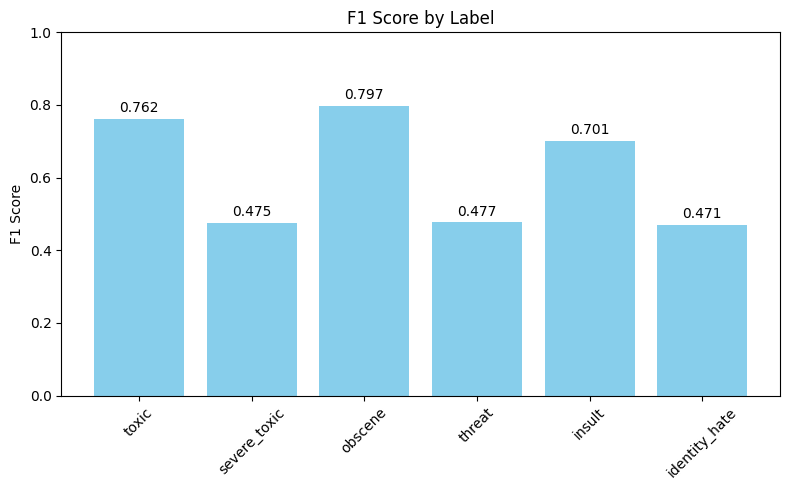

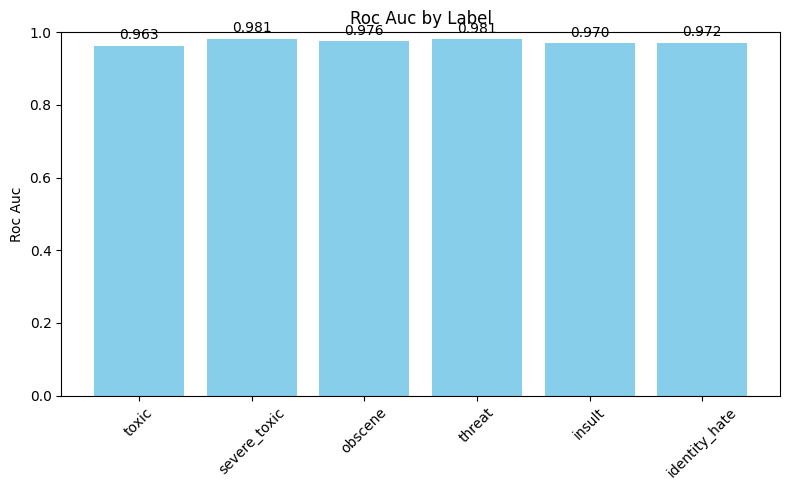

In [110]:
# Plot metrics per label
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

for metric in metrics:
    values = [results[label][metric] for label in toxicity_labels]

    plt.figure(figsize=(8, 5))
    plt.bar(toxicity_labels, values, color='skyblue')
    plt.title(f'{metric.replace("_", " ").title()} by Label')
    plt.ylabel(metric.replace("_", " ").title())
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

    for j, v in enumerate(values):
        plt.text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

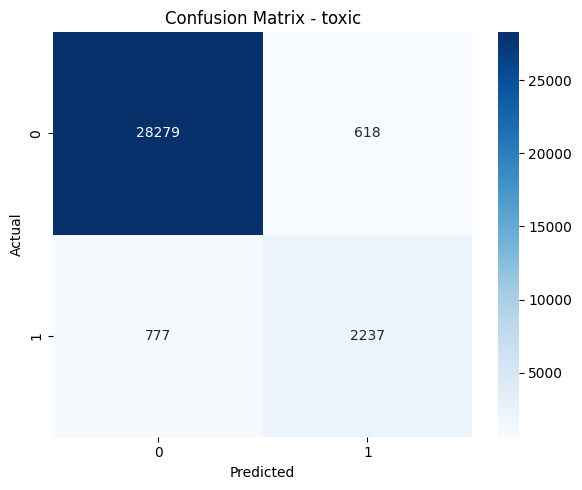

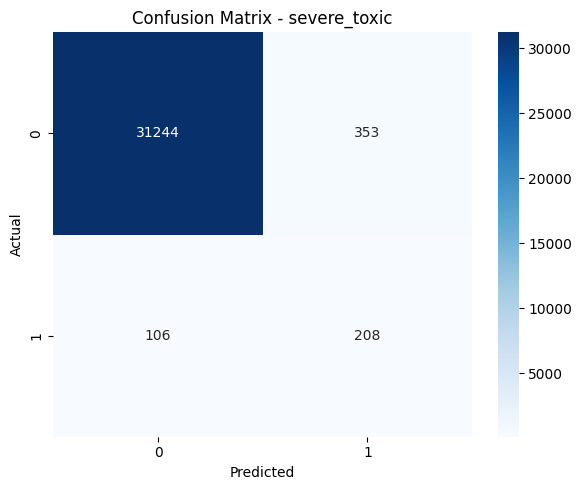

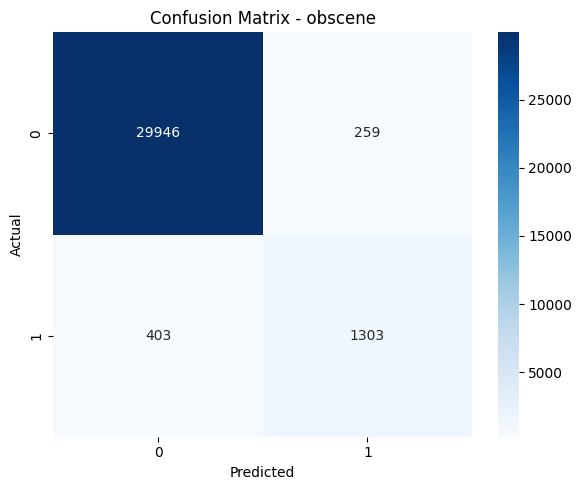

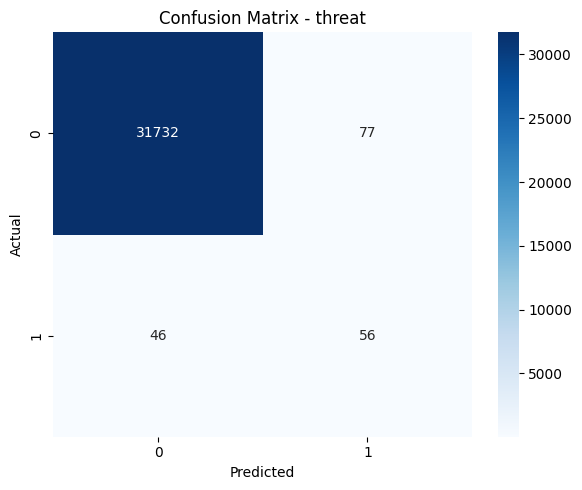

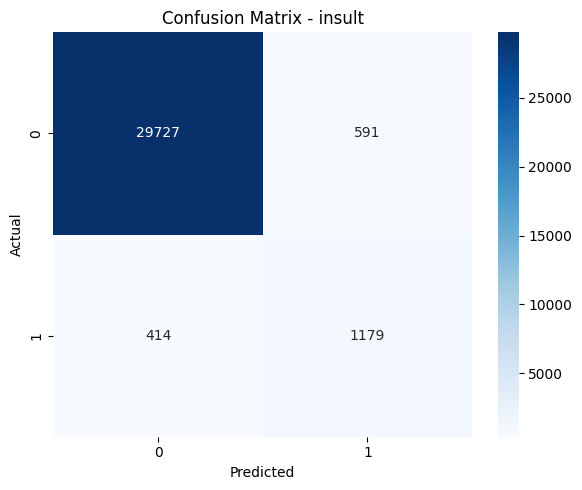

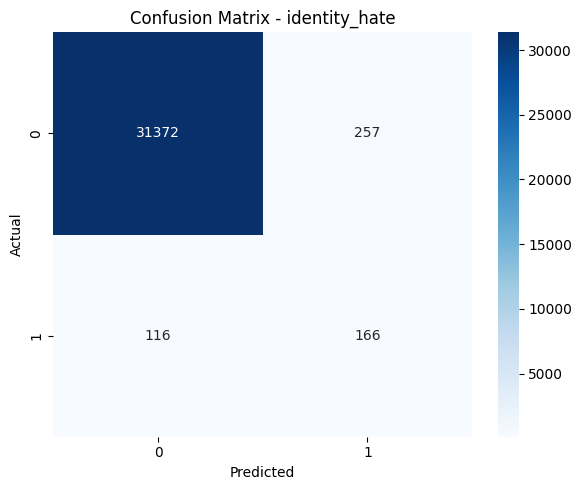

In [111]:
# Plot confusion matrix per label
for i, label in enumerate(toxicity_labels):
    cm = confusion_matrix(y_test[:, i], y_pred_all[:, i])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

## **Naive Bayes**

In [112]:
nb_models = {}
nb_thresholds = {}
nb_results = {}


In [113]:
from sklearn.naive_bayes import MultinomialNB # Import MultinomialNB

# Train Naive Bayes per label with oversampling + class weights + threshold tuning
for i, label in enumerate(toxicity_labels):
    print(f"\nTraining model for '{label}'...")

    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train[:, i])

    clf = MultinomialNB()
    clf.fit(X_resampled, y_resampled)
    nb_models[label] = clf

    y_prob = clf.predict_proba(X_test)[:, 1]

    best_thresh = 0.5
    best_f1 = 0
    for t in np.arange(0.1, 0.9, 0.01):
        y_pred_t = (y_prob >= t).astype(int)
        f1 = f1_score(y_test[:, i], y_pred_t, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    nb_thresholds[label] = best_thresh
    y_pred = (y_prob >= best_thresh).astype(int)

    nb_results[label] = {
        'accuracy': accuracy_score(y_test[:, i], y_pred),
        'precision': precision_score(y_test[:, i], y_pred, zero_division=0),
        'recall': recall_score(y_test[:, i], y_pred, zero_division=0),
        'f1_score': best_f1,
        'roc_auc': roc_auc_score(y_test[:, i], y_prob)
    }

    print(f"{label.upper()} threshold: {best_thresh:.2f}")
    print(f"Accuracy:  {results[label]['accuracy']:.4f}")
    print(f"Precision: {results[label]['precision']:.4f}")
    print(f"Recall:    {results[label]['recall']:.4f}")
    print(f"F1-Score:  {results[label]['f1_score']:.4f}")
    print(f"ROC-AUC:   {results[label]['roc_auc']:.4f}")


Training model for 'toxic'...
TOXIC threshold: 0.82
Accuracy:  0.9563
Precision: 0.7835
Recall:    0.7422
F1-Score:  0.7623
ROC-AUC:   0.9628

Training model for 'severe_toxic'...
SEVERE_TOXIC threshold: 0.89
Accuracy:  0.9856
Precision: 0.3708
Recall:    0.6624
F1-Score:  0.4754
ROC-AUC:   0.9814

Training model for 'obscene'...
OBSCENE threshold: 0.88
Accuracy:  0.9793
Precision: 0.8342
Recall:    0.7638
F1-Score:  0.7974
ROC-AUC:   0.9756

Training model for 'threat'...
THREAT threshold: 0.88
Accuracy:  0.9961
Precision: 0.4211
Recall:    0.5490
F1-Score:  0.4766
ROC-AUC:   0.9807

Training model for 'insult'...
INSULT threshold: 0.88
Accuracy:  0.9685
Precision: 0.6661
Recall:    0.7401
F1-Score:  0.7012
ROC-AUC:   0.9698

Training model for 'identity_hate'...
IDENTITY_HATE threshold: 0.89
Accuracy:  0.9883
Precision: 0.3924
Recall:    0.5887
F1-Score:  0.4709
ROC-AUC:   0.9717


In [114]:
y_pred_all_nb = np.zeros_like(y_test)
for i, label in enumerate(toxicity_labels):
    prob = nb_models[label].predict_proba(X_test)[:, 1]
    y_pred_all_nb[:, i] = (prob >= nb_thresholds[label]).astype(int)

In [115]:
for i, label in enumerate(toxicity_labels):
    print(f"\n[Naive Bayes] Classification report for '{label}':")
    print(classification_report(y_test[:, i], y_pred_all_nb[:, i]))


[Naive Bayes] Classification report for 'toxic':
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     28897
           1       0.77      0.67      0.72      3014

    accuracy                           0.95     31911
   macro avg       0.87      0.82      0.84     31911
weighted avg       0.95      0.95      0.95     31911


[Naive Bayes] Classification report for 'severe_toxic':
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     31597
           1       0.25      0.76      0.38       314

    accuracy                           0.98     31911
   macro avg       0.62      0.87      0.68     31911
weighted avg       0.99      0.98      0.98     31911


[Naive Bayes] Classification report for 'obscene':
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     30205
           1       0.71      0.69      0.70      1706

    accuracy           

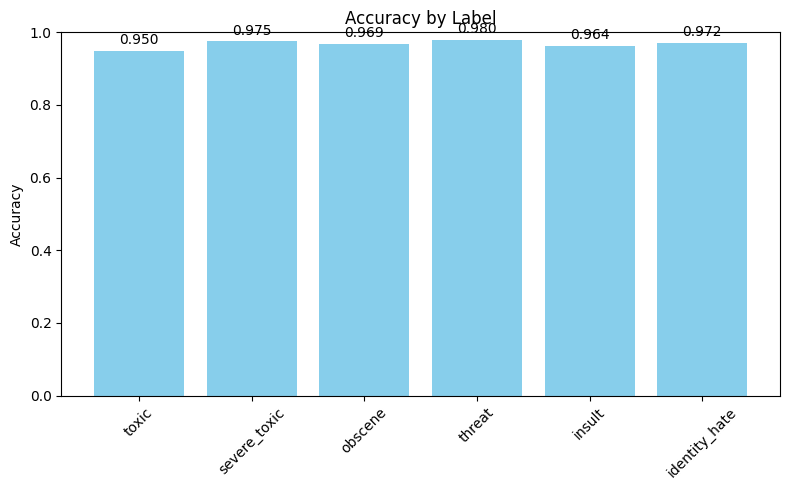

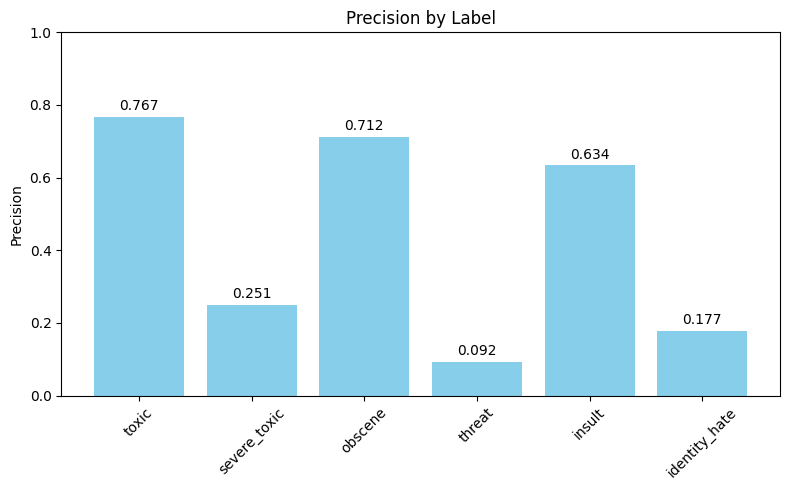

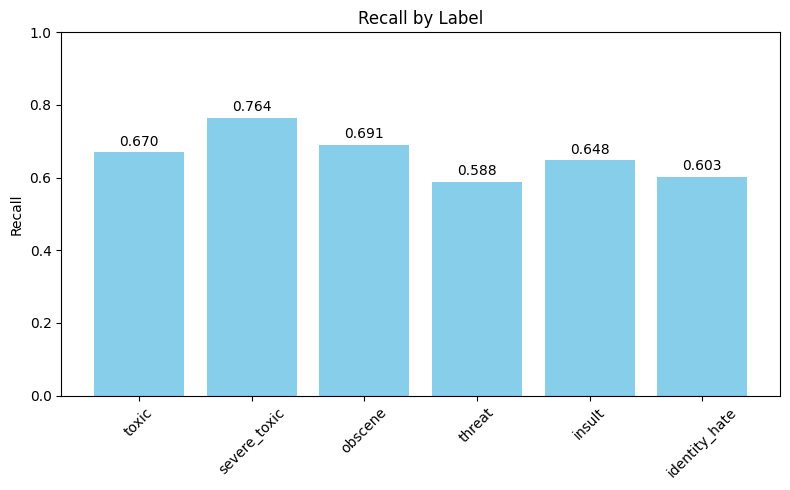

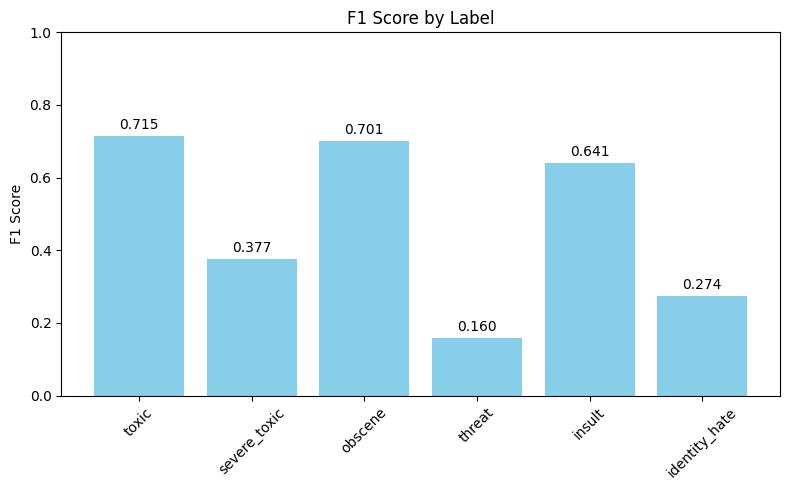

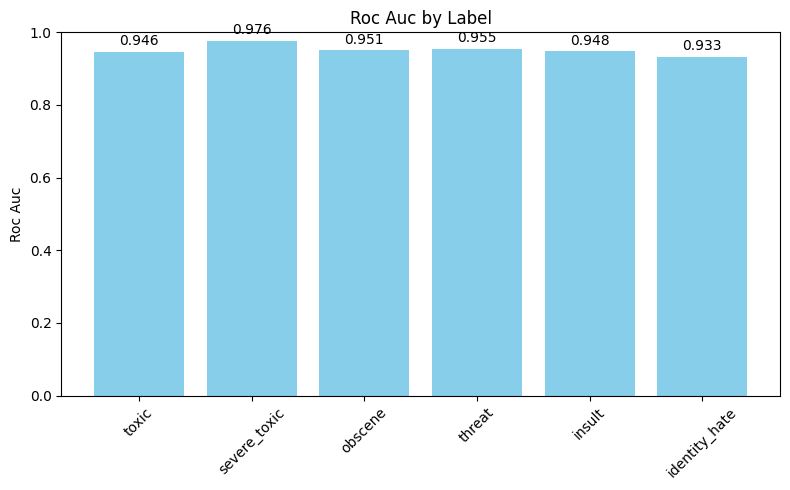

In [116]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

for metric in metrics:
    values = [nb_results[label][metric] for label in toxicity_labels]

    plt.figure(figsize=(8, 5))
    plt.bar(toxicity_labels, values, color='skyblue')
    plt.title(f'{metric.replace("_", " ").title()} by Label')
    plt.ylabel(metric.replace("_", " ").title())
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

    for j, v in enumerate(values):
        plt.text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [117]:
sample_comments = [
    "You are absolutely stupid and worthless!",
    "I completely disagree with your political views",
    "This is a wonderful discussion, thank you for sharing",
    "Kill yourself you moron",
    "I think we should consider alternative approaches"
]
nb_processed_comments = [preprocess_text(comment) for comment in sample_comments]
X_sample = vectorizer.transform(nb_processed_comments)

for i, comment in enumerate(sample_comments):
    print(f"\nComment: '{comment}'")
    print("Predictions:")
    for label in toxicity_labels:
        model = nb_models[label]
        prob = model.predict_proba(X_sample[i:i+1])[:, 1][0]
        pred = int(prob >= nb_thresholds[label])
        status = "TOXIC" if pred == 1 else "NOT TOXIC"
        print(f"  {label}: {status} (probability: {prob:.4f})")



Comment: 'You are absolutely stupid and worthless!'
Predictions:
  toxic: TOXIC (probability: 0.9686)
  severe_toxic: TOXIC (probability: 0.9306)
  obscene: TOXIC (probability: 0.9266)
  threat: TOXIC (probability: 0.9485)
  insult: TOXIC (probability: 0.9546)
  identity_hate: NOT TOXIC (probability: 0.6944)

Comment: 'I completely disagree with your political views'
Predictions:
  toxic: NOT TOXIC (probability: 0.2548)
  severe_toxic: NOT TOXIC (probability: 0.0238)
  obscene: NOT TOXIC (probability: 0.0815)
  threat: NOT TOXIC (probability: 0.0008)
  insult: NOT TOXIC (probability: 0.1192)
  identity_hate: NOT TOXIC (probability: 0.1299)

Comment: 'This is a wonderful discussion, thank you for sharing'
Predictions:
  toxic: NOT TOXIC (probability: 0.1820)
  severe_toxic: NOT TOXIC (probability: 0.0048)
  obscene: NOT TOXIC (probability: 0.0543)
  threat: NOT TOXIC (probability: 0.0039)
  insult: NOT TOXIC (probability: 0.0484)
  identity_hate: NOT TOXIC (probability: 0.0551)

Commen

 ## **Comaring both of the ML models**

**📊 1. Metrics Table**





In [118]:
import pandas as pd

# Define table rows
table_rows = []

for label in toxicity_labels:
    lr_metrics = results[label]
    nb_metrics = nb_results[label]

    table_rows.append({
        'Label': label,
        'Model': 'Logistic Regression',
        'Accuracy': lr_metrics['accuracy'],
        'Precision': lr_metrics['precision'],
        'Recall': lr_metrics['recall'],
        'F1 Score': lr_metrics['f1_score'],
        'ROC-AUC': lr_metrics['roc_auc']
    })

    table_rows.append({
        'Label': label,
        'Model': 'Naive Bayes',
        'Accuracy': nb_metrics['accuracy'],
        'Precision': nb_metrics['precision'],
        'Recall': nb_metrics['recall'],
        'F1 Score': nb_metrics['f1_score'],
        'ROC-AUC': nb_metrics['roc_auc']
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(table_rows)

# Display rounded table
pd.set_option('display.max_columns', None)
print(metrics_df.round(4))


            Label                Model  Accuracy  Precision  Recall  F1 Score  \
0           toxic  Logistic Regression    0.9563     0.7835  0.7422    0.7623   
1           toxic          Naive Bayes    0.9496     0.7674  0.6699    0.7153   
2    severe_toxic  Logistic Regression    0.9856     0.3708  0.6624    0.4754   
3    severe_toxic          Naive Bayes    0.9752     0.2505  0.7643    0.3774   
4         obscene  Logistic Regression    0.9793     0.8342  0.7638    0.7974   
5         obscene          Naive Bayes    0.9685     0.7120  0.6911    0.7014   
6          threat  Logistic Regression    0.9961     0.4211  0.5490    0.4766   
7          threat          Naive Bayes    0.9802     0.0924  0.5882    0.1598   
8          insult  Logistic Regression    0.9685     0.6661  0.7401    0.7012   
9          insult          Naive Bayes    0.9637     0.6339  0.6478    0.6408   
10  identity_hate  Logistic Regression    0.9883     0.3924  0.5887    0.4709   
11  identity_hate          N

**📈 2. Bar Plot Comparison (F1-score or ROC-AUC)**


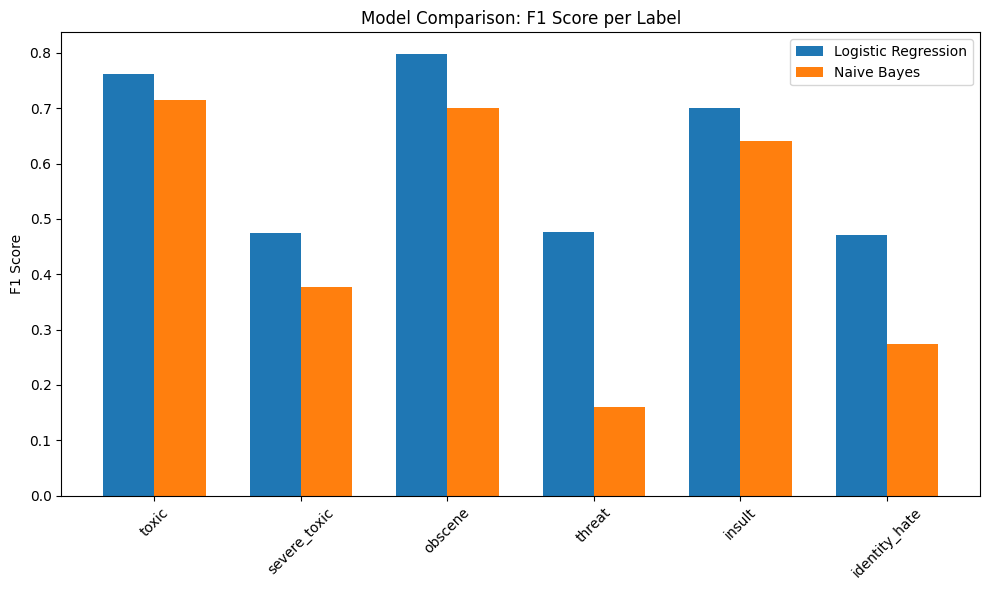

In [119]:
labels = toxicity_labels
lr_f1 = [results[label]['f1_score'] for label in labels]
nb_f1 = [nb_results[label]['f1_score'] for label in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, lr_f1, width, label='Logistic Regression')
plt.bar(x + width/2, nb_f1, width, label='Naive Bayes')
plt.xticks(x, labels, rotation=45)
plt.ylabel("F1 Score")
plt.title("Model Comparison: F1 Score per Label")
plt.legend()
plt.tight_layout()
plt.show()


Logistic Regression outperformed Naive Bayes across all labels especially on “toxic” and “insult” which it had a higher F1-scores and ROC-AUC. This means that LR captures feature interactions better when TF-IDF features are used.

